In [2]:
import pandas as pd
from prophet import Prophet
import datetime
import pytz

Importing plotly failed. Interactive plots will not work.


In [4]:
import yfinance as yf
import os
import pandas as pd
import matplotlib.pyplot as plt

## Here we will download the data of given Ticker
ticker = 'TCS.NS'
stockTicker = yf.Ticker(ticker)
stockInfo = stockTicker.info
stocks = stockTicker.history(period='3y') #, interval='1wk')

In [50]:
## Preprocessing of Stock data
stocks['Average'] = stocks[['Open', 'High', 'Low', 'Close']].mean(numeric_only=True, axis=1)
df = stocks.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'])
df['Average'] = df['Average'].rolling(10).mean()
df = df.dropna()
df = df.rename(columns={'Average': 'y'})
df['ds'] = df.index
df['ds'] = df['ds'].apply(lambda x: x.date())
df = df.reset_index()
train_df = df[:int(len(df)*0.97)]

In [51]:
## Model Initialization and Fit
m = Prophet()
m.fit(train_df)

12:51:56 - cmdstanpy - INFO - Chain [1] start processing
12:51:56 - cmdstanpy - INFO - Chain [1] done processing


In [52]:
## Future Forecasting

future = m.make_future_dataframe(periods=60)
future['day'] = future['ds'].dt.weekday
future = future[future['day'] <5]
forecast = m.predict(df)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2020-12-29,2719.775441,2626.033068,2811.425951
1,2020-12-30,2729.242668,2639.915561,2829.095656
2,2020-12-31,2739.339554,2646.583580,2835.701491
3,2021-01-01,2745.980950,2643.892727,2843.333056
4,2021-01-04,2775.180870,2679.229230,2867.258063
...,...,...,...,...
730,2023-12-11,3588.130293,3492.094271,3679.312656
731,2023-12-12,3585.022785,3488.894573,3684.406711
732,2023-12-13,3585.237741,3487.365614,3677.732030
733,2023-12-14,3584.712254,3483.972513,3682.199057


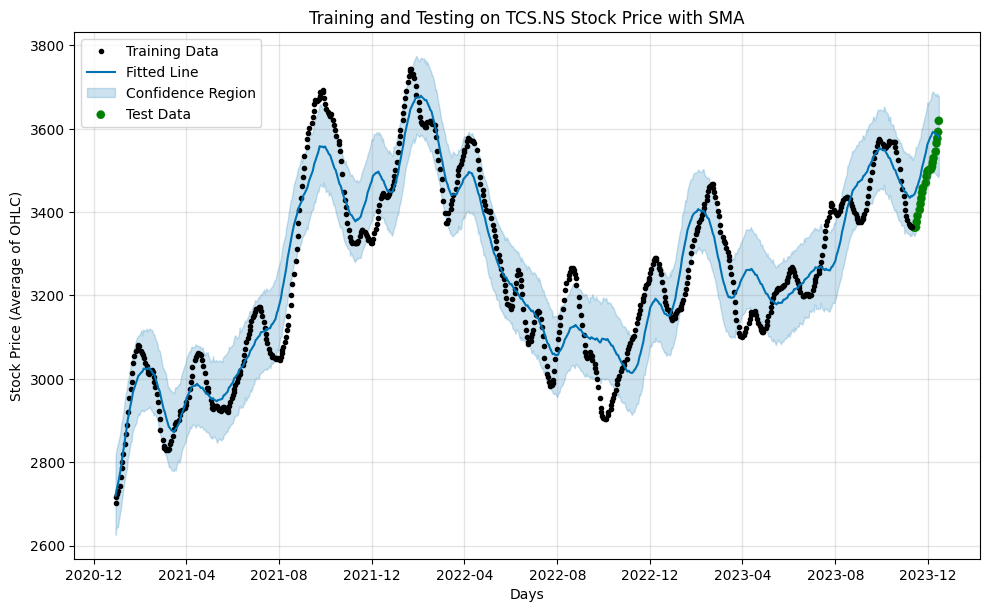

In [54]:
## Forecast plot

fig1 = m.plot(forecast)
plt.legend(["Training"])
color = int(len(df)*0.03 +1)*['green']
plt.scatter(df['ds'][int(len(df)*0.97):], df['y'][int(len(df)*0.97):], c=color, linewidths=0.2)
plt.xlabel("Days")
plt.ylabel("Stock Price (Average of OHLC)")
plt.title(f"Training and Testing on {ticker} Stock Price with SMA")
plt.legend(['Training Data', 'Fitted Line', 'Confidence Region', 'Test Data'], loc='upper left')

In [55]:
fig1.savefig(f'{ticker}_TrainTest_SMA.png', dpi=480, bbox_inches='tight')

In [56]:
predicted_price

0      2775.180870
1      2861.545142
2      2940.292186
3      2990.976619
4      3015.851255
          ...     
149    3588.130293
150    3567.790204
151    3555.046016
152    3581.956651
153    3648.698460
Name: yhat, Length: 154, dtype: float64

In [57]:
# Error Calculation
import numpy as np
train_mape = 0
test_mape = 0

original_price, predicted_price = df['y'], forecast['yhat']

for i in range(int(len(df)*0.97)):
    train_mape += abs(original_price[i] - predicted_price[i])/original_price[i]
    
for i in range(int(len(df)*0.97), len(df)):
    test_mape += abs(original_price[i] - predicted_price[i])/original_price[i]
    print(100*(abs(original_price[i] - predicted_price[i]))/original_price[i])

2.3876945743304483
2.624905974474295
2.4533747311392804
2.1045757316136364
2.211633085750341
1.9722388270792717
1.8851048476549834
1.7730151284260196
1.6287889536519204
2.111877662675307
1.9458237246929988
1.8975647554611257
1.9143933884264945
2.241470035517598
2.251108437557801
2.2523991905478344
2.0811229893954426
1.7456808855269765
1.2137250419804806
0.5594982676747002
0.24108673389809174
0.20479830005969055
1.0872136826369603


In [58]:
print(f"Train Absolute Percentage Error (APE): {train_mape}, and Test APE: {test_mape}")
print(f"Train Mean Absolute Percentage Error (MAPE): {train_mape/int(len(df)*0.97)}, Test MAPE: {test_mape/(len(df) - int(len(df)*0.97))}")

Train Absolute Percentage Error (APE): 13.408326073736138, and Test APE: 0.40789094950171706
Train Mean Absolute Percentage Error (MAPE): 0.018831918642887833, Test MAPE: 0.01773438910877031
